In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns
# Needed for Linear regression
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from sklearn.pipeline import make_pipeline
from sklearn.pipeline import make_union
from sklearn.compose import make_column_transformer

from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler


# Preprocessing

In [2]:
#Reading Raw X_train
train = pd.read_csv('raw_data/train.csv')
test = pd.read_csv('raw_data/test.csv')

# target
y_train = train[['pv_production', 'wind_production', 'consumption']]
y_test =  test[['pv_production', 'wind_production', 'consumption']]

In [3]:
#Log columns
f_logs = [
    'precip_1h:mm',
    'prob_precip_1h:p',
    'clear_sky_rad:W',
    'clear_sky_energy_1h:J',
    'diffuse_rad:W',
    'diffuse_rad_1h:Wh',
    'direct_rad:W',
    'direct_rad_1h:Wh',
    'global_rad:W',
    'global_rad_1h:Wh',
    'wind_speed_2m:ms',
    'wind_speed_10m:ms',
    'wind_speed_50m:ms',
    'wind_speed_100m:ms'
]

epsilon = 1e-5

for f in f_logs:
    train[f] = np.log(train[f] + epsilon)
    test[f] = np.log(test[f] + epsilon)

# Converting time to datetime
# We might have done that before already
train['time'] = pd.to_datetime(train['time'])
test['time'] = pd.to_datetime(test['time'])

# The following two steps create new columns to get the input for the sine & cosine columns
# Creating columns indicating the hour and the month
train['hour'] = train['time'].dt.hour
train['month'] = train['time'].dt.month

test['hour'] = test['time'].dt.hour
test['month'] = test['time'].dt.month

# Creating column indicating the season
def assign_season(month):
    if month in [3, 4, 5]:
        return 1  # Spring
    elif month in [6, 7, 8]:
        return 2  # Summer
    elif month in [9, 10, 11]:
        return 3  # Fall
    else:  # December, January, February
        return 4  # Winter

# train
train['season'] = train['month'].apply(assign_season)

train['hour_sine'] = np.sin(2 * np.pi * train['hour'] / 24)
train['hour_cosine'] = np.cos(2 * np.pi * train['hour'] / 24)

train['month_sine'] = np.sin(2 * np.pi * train['month'] / 12)
train['month_cosine'] = np.cos(2 * np.pi * train['month'] / 12)

train['season_sine'] = np.sin(2 * np.pi * train['season'] / 4)
train['season_cosine'] = np.cos(2 * np.pi * train['season'] / 4)

train = train.drop(columns=['hour', 'month', 'season'])

# test
test['season'] = test['month'].apply(assign_season)

test['hour_sine'] = np.sin(2 * np.pi * test['hour'] / 24)
test['hour_cosine'] = np.cos(2 * np.pi * test['hour'] / 24)

test['month_sine'] = np.sin(2 * np.pi * test['month'] / 12)
test['month_cosine'] = np.cos(2 * np.pi * test['month'] / 12)

test['season_sine'] = np.sin(2 * np.pi * test['season'] / 4)
test['season_cosine'] = np.cos(2 * np.pi * test['season'] / 4)

test = test.drop(columns=['hour', 'month', 'season'])

# Cyclic features
cyclical_features = ['sun_azimuth:d', 'wind_dir_2m:d', 'wind_dir_10m:d', 'wind_dir_50m:d', 'wind_dir_100m:d']
degrees = 360

for cyclical_feature in cyclical_features:
    sin_column_name = f'sin_{cyclical_feature}'
    cos_column_name = f'cos_{cyclical_feature}'
    train[sin_column_name] = np.sin(2 * np.pi * train[cyclical_feature] / 2)
    train[cos_column_name] = np.cos(2 * np.pi * train[cyclical_feature] / degrees)
    test[sin_column_name] = np.sin(2 * np.pi * test[cyclical_feature] / 2)
    test[cos_column_name] = np.cos(2 * np.pi * test[cyclical_feature] / degrees)

train = train.drop(columns=cyclical_features)
test = test.drop(columns=cyclical_features)

# targets = ['pv_production', 'wind_production', 'consumption']
f_minmax = [
    'hour_sine',
    'hour_cosine',
    'month_sine',
    'month_cosine',
    'season_sine',
    'season_cosine',
    'precip_1h:mm',
    'prob_precip_1h:p',
    'clear_sky_rad:W',
    'clear_sky_energy_1h:J',
    'diffuse_rad:W',
    'diffuse_rad_1h:Wh',
    'direct_rad:W',
    'direct_rad_1h:Wh',
    'global_rad:W',
    'global_rad_1h:Wh',
    'sunshine_duration_1h:min',
    'low_cloud_cover:p',
    'medium_cloud_cover:p',
    'high_cloud_cover:p',
    'total_cloud_cover:p',
    'effective_cloud_cover:p',
    'sin_sun_azimuth:d',
    'cos_sun_azimuth:d',
    'sin_wind_dir_2m:d',
    'cos_wind_dir_2m:d',
    'sin_wind_dir_10m:d',
    'cos_wind_dir_10m:d',
    'sin_wind_dir_50m:d',
    'cos_wind_dir_50m:d',
    'sin_wind_dir_100m:d',
    'cos_wind_dir_100m:d',
    'relative_humidity_2m:p',
    'relative_humidity_10m:p',
    'relative_humidity_50m:p',
    'relative_humidity_100m:p',
    'dew_point_2m:C',
    'dew_point_10m:C',
    'dew_point_50m:C',
    'dew_point_100m:C',
    'temp'
]
f_standard = ['sun_elevation:d']
f_robust = [
    't_10m:C',
    't_50m:C',
    't_100m:C',
    'wind_speed_2m:ms',
    'wind_speed_10m:ms',
    'wind_speed_50m:ms',
    'wind_speed_100m:ms'
]

f_ohe = ['precip_type:idx']

# other = ['spot_market_price']

# features , drop target columns
X_train = train.drop(columns=['time', 'pv_production', 'wind_production', 'consumption', 'spot_market_price'])
X_test = test.drop(columns=['time', 'pv_production', 'wind_production', 'consumption', 'spot_market_price'])

# Preprocessing Pipeline
minmax_scaler = MinMaxScaler()
standard_scaler = StandardScaler()
cat_transformer = OneHotEncoder()
robust_scaler = RobustScaler()

preproc_basic = make_column_transformer(
    (minmax_scaler, f_minmax ),
    (standard_scaler, f_standard),
    (robust_scaler, f_robust),
    (cat_transformer, f_ohe),
    remainder='passthrough'
)
# Train X
X_train_transformed = preproc_basic.fit_transform(X_train)
# Adding Column names
X_train_transformed = pd.DataFrame(
    X_train_transformed,
    columns=preproc_basic.get_feature_names_out()
)

# Test x
X_test_transformed = preproc_basic.transform(X_test)
# Adding Column names
X_test_transformed = pd.DataFrame(
    X_test_transformed,
    columns=preproc_basic.get_feature_names_out()
)


In [4]:
X_train_transformed.head()

,minmaxscaler__hour_sine,minmaxscaler__hour_cosine,minmaxscaler__month_sine,minmaxscaler__month_cosine,minmaxscaler__season_sine,minmaxscaler__season_cosine,minmaxscaler__precip_1h:mm,minmaxscaler__prob_precip_1h:p,minmaxscaler__clear_sky_rad:W,minmaxscaler__clear_sky_energy_1h:J,...,robustscaler__t_50m:C,robustscaler__t_100m:C,robustscaler__wind_speed_2m:ms,robustscaler__wind_speed_10m:ms,robustscaler__wind_speed_50m:ms,robustscaler__wind_speed_100m:ms,onehotencoder__precip_type:idx_0.0,onehotencoder__precip_type:idx_1.0,onehotencoder__precip_type:idx_2.0,onehotencoder__precip_type:idx_3.0
0,0.370590,0.017037,0.75,0.933013,0.5,1.0,0.0,0.0,0.757424,0.854846,...,0.422222,0.417582,1.002449,0.912001,0.919976,0.936622,1.0,0.0,0.0,0.0
1,0.250000,0.066987,0.75,0.933013,0.5,1.0,0.0,0.0,0.000000,0.779972,...,0.422222,0.428571,0.903413,0.845489,0.859477,0.887809,1.0,0.0,0.0,0.0
2,0.146447,0.146447,0.75,0.933013,0.5,1.0,0.0,0.0,0.000000,0.000000,...,0.433333,0.428571,1.180455,1.111203,1.085550,1.083210,1.0,0.0,0.0,0.0
3,0.066987,0.250000,0.75,0.933013,0.5,1.0,0.0,0.0,0.000000,0.000000,...,0.422222,0.417582,1.520273,1.434093,1.372530,1.332958,1.0,0.0,0.0,0.0
4,0.017037,0.370590,0.75,0.933013,0.5,1.0,0.0,0.0,0.000000,0.000000,...,0.288889,0.285714,1.476824,1.375834,1.330847,1.297649,1.0,0.0,0.0,0.0


In [5]:
sorted(X_train_transformed.columns)

['minmaxscaler__clear_sky_energy_1h:J',
 'minmaxscaler__clear_sky_rad:W',
 'minmaxscaler__cos_sun_azimuth:d',
 'minmaxscaler__cos_wind_dir_100m:d',
 'minmaxscaler__cos_wind_dir_10m:d',
 'minmaxscaler__cos_wind_dir_2m:d',
 'minmaxscaler__cos_wind_dir_50m:d',
 'minmaxscaler__dew_point_100m:C',
 'minmaxscaler__dew_point_10m:C',
 'minmaxscaler__dew_point_2m:C',
 'minmaxscaler__dew_point_50m:C',
 'minmaxscaler__diffuse_rad:W',
 'minmaxscaler__diffuse_rad_1h:Wh',
 'minmaxscaler__direct_rad:W',
 'minmaxscaler__direct_rad_1h:Wh',
 'minmaxscaler__effective_cloud_cover:p',
 'minmaxscaler__global_rad:W',
 'minmaxscaler__global_rad_1h:Wh',
 'minmaxscaler__high_cloud_cover:p',
 'minmaxscaler__hour_cosine',
 'minmaxscaler__hour_sine',
 'minmaxscaler__low_cloud_cover:p',
 'minmaxscaler__medium_cloud_cover:p',
 'minmaxscaler__month_cosine',
 'minmaxscaler__month_sine',
 'minmaxscaler__precip_1h:mm',
 'minmaxscaler__prob_precip_1h:p',
 'minmaxscaler__relative_humidity_100m:p',
 'minmaxscaler__relative_

In [6]:
X_train_transformed.shape

(9515, 53)

In [7]:
test = X_train_transformed.dropna()

In [8]:
test.shape

(9515, 53)

In [9]:
correlation_matrix = X_train_transformed.corr()

<Axes: >

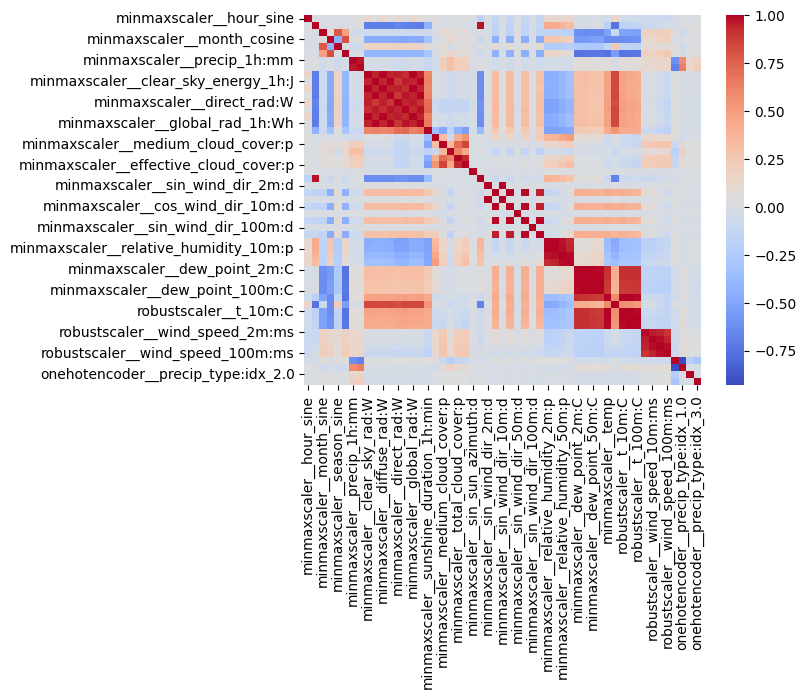

In [10]:
sns.heatmap(correlation_matrix, cmap='coolwarm')

In [11]:
y_train.head()

,pv_production,wind_production,consumption
0,0.0,40.59,26.514689
1,0.0,67.86,28.326960
2,0.0,116.68,23.682207
3,0.0,120.22,25.354782
4,0.0,109.86,23.861942


# Experiments Baseline Model - Linear Regression

In [12]:
targets = ['pv_production', 'wind_production', 'consumption']

In [13]:
model = LinearRegression()
model.fit(X_train_transformed, y_train)
y_pred = model.predict(X_test_transformed)
y_pred = pd.DataFrame(y_pred, columns = targets)

In [14]:
# Compute scores for each target using all Features

mae_per_target = {}
mse_per_target = {}
r2_per_target = {}

for column in y_test.columns:
    mae_per_target[column] = round(float(mean_absolute_error(y_test[column], y_pred[column])),2)
    mse_per_target[column] = round(float(mean_squared_error(y_test[column], y_pred[column])),2)
    r2_per_target[column] = round(float(r2_score(y_test[column], y_pred[column])),2)
    
print("\nMAE per column:")
print(mae_per_target)

print("\nMSE per column:")
print(
    )

print("\nR2 per column:")
print(r2_per_target)


MAE per column:
{'pv_production': 4.72, 'wind_production': 22.75, 'consumption': 17.73}

MSE per column:
{'pv_production': 45.66, 'wind_production': 853.58, 'consumption': 415.26}

R2 per column:
{'pv_production': 0.51, 'wind_production': -0.11, 'consumption': -1.57}


## PV Production

In [15]:
model = LinearRegression()
model.fit(X_train_transformed, y_train['pv_production'])
y_pred_pv_production = model.predict(X_test_transformed)

In [16]:
model.score(X_test_transformed, y_test['pv_production']) #Return the coefficient of determination of the prediction = r2

0.50731851243251

In [17]:
# Evaluate the model
mse = mean_squared_error(y_test['pv_production'], y_pred_pv_production)
r2 = r2_score(y_test['pv_production'], y_pred_pv_production)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R-squared (R²): {r2:.4f}")

# Get coefficients
coefficients = model.coef_

# Combine coefficients with feature names
coef_df = pd.DataFrame({"Feature": X_train_transformed.columns, "Coefficient": coefficients})
# Sort features by importance
coef_df["Importance"] = coef_df["Coefficient"].abs()
important_features = coef_df.sort_values("Importance", ascending=False)
print("Top 10 Features by Importance:")
print(important_features.head(10))

Mean Squared Error (MSE): 45.6583
R-squared (R²): 0.5073
Top 10 Features by Importance:
                                Feature  Coefficient  Importance
40                   minmaxscaler__temp   395.583458  395.583458
36         minmaxscaler__dew_point_2m:C  -265.168482  265.168482
15       minmaxscaler__global_rad_1h:Wh   256.057795  256.057795
10          minmaxscaler__diffuse_rad:W  -228.929145  228.929145
38        minmaxscaler__dew_point_50m:C   134.326165  134.326165
9   minmaxscaler__clear_sky_energy_1h:J  -128.092163  128.092163
14           minmaxscaler__global_rad:W   122.065116  122.065116
8         minmaxscaler__clear_sky_rad:W   111.230609  111.230609
11      minmaxscaler__diffuse_rad_1h:Wh  -105.557095  105.557095
39       minmaxscaler__dew_point_100m:C    92.419257   92.419257


In [18]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score

# Ridge Regression
ridge = Ridge(alpha=1.0)  # Alpha is the regularization strength
ridge.fit(X_train_transformed, y_train['pv_production'])
ridge_pred = ridge.predict(X_test_transformed)
ridge_mse = mean_squared_error(y_test['pv_production'], ridge_pred)
ridge_r2 = r2_score(y_test['pv_production'], ridge_pred)
print(f"Ridge Regression - MSE: {ridge_mse:.4f}, R²: {ridge_r2:.4f}")

# Lasso Regression
lasso = Lasso(alpha=0.1)  # Alpha is the regularization strength
lasso.fit(X_train_transformed, y_train['pv_production'])
lasso_pred = lasso.predict(X_test_transformed)
lasso_mse = mean_squared_error(y_test['pv_production'], lasso_pred)
lasso_r2 = r2_score(y_test['pv_production'], lasso_pred)
print(f"Lasso Regression - MSE: {lasso_mse:.4f}, R²: {lasso_r2:.4f}")

# Get coefficients
coefficients = lasso.coef_

# Combine coefficients with feature names
coef_df = pd.DataFrame({"Feature": X_train_transformed.columns, "Coefficient": coefficients})

# Filter features used in the model (non-zero coefficients)
used_features = coef_df[coef_df["Coefficient"] != 0]

print("\nFeatures Used in the Model:")
print(used_features)
print("\nAll Coefficients:")
print(coef_df)

Ridge Regression - MSE: 46.1013, R²: 0.5025
Lasso Regression - MSE: 53.5840, R²: 0.4218

Features Used in the Model:
                                   Feature   Coefficient
0                  minmaxscaler__hour_sine  2.745003e+00
2                 minmaxscaler__month_sine  7.352430e-01
6               minmaxscaler__precip_1h:mm -1.010111e+00
11         minmaxscaler__diffuse_rad_1h:Wh -9.114950e+00
12              minmaxscaler__direct_rad:W  7.910715e+00
16  minmaxscaler__sunshine_duration_1h:min  5.615573e+00
18      minmaxscaler__medium_cloud_cover:p -1.179864e+00
19        minmaxscaler__high_cloud_cover:p -5.461808e-01
23         minmaxscaler__cos_sun_azimuth:d -6.428529e+00
25         minmaxscaler__cos_wind_dir_2m:d  1.301748e+00
27        minmaxscaler__cos_wind_dir_10m:d  2.542882e-16
31       minmaxscaler__cos_wind_dir_100m:d  6.070966e-01
32    minmaxscaler__relative_humidity_2m:p -1.914299e+01
41         standardscaler__sun_elevation:d  4.667061e+00
42                   robusts

In [19]:
model.intercept_

np.float64(-137.54915864610874)

In [20]:
model.get_params()

{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}

In [21]:
y_pred_pv_production.mean()

np.float64(3.9198051446126154)

## Wind Production

In [22]:
model = LinearRegression()
model.fit(X_train_transformed, y_train['wind_production'])
y_pred_wind_production = model.predict(X_test_transformed)

In [23]:
# Evaluate the model
mse = mean_squared_error(y_test['wind_production'], y_pred_wind_production)
r2 = r2_score(y_test['wind_production'], y_pred_wind_production)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R-squared (R²): {r2:.4f}")

# Get coefficients
coefficients = model.coef_

# Combine coefficients with feature names
coef_df = pd.DataFrame({"Feature": X_train_transformed.columns, "Coefficient": coefficients})
# Sort features by importance
coef_df["Importance"] = coef_df["Coefficient"].abs()
important_features = coef_df.sort_values("Importance", ascending=False)
print("\nTop 10 Features by Importance:")
print(important_features.head(10))

Mean Squared Error (MSE): 853.5838
R-squared (R²): -0.1060

Top 10 Features by Importance:
                                   Feature  Coefficient  Importance
40                      minmaxscaler__temp  -399.752084  399.752084
32    minmaxscaler__relative_humidity_2m:p  -357.048871  357.048871
33   minmaxscaler__relative_humidity_10m:p   304.857988  304.857988
34   minmaxscaler__relative_humidity_50m:p  -178.683882  178.683882
35  minmaxscaler__relative_humidity_100m:p   139.892753  139.892753
43                   robustscaler__t_50m:C   135.811557  135.811557
39          minmaxscaler__dew_point_100m:C  -129.203546  129.203546
14              minmaxscaler__global_rad:W  -119.122171  119.122171
37           minmaxscaler__dew_point_10m:C   105.849980  105.849980
36            minmaxscaler__dew_point_2m:C   102.693094  102.693094


In [24]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score

# Ridge Regression
ridge = Ridge(alpha=1.0)  # Alpha is the regularization strength
ridge.fit(X_train_transformed, y_train['wind_production'])
ridge_pred = ridge.predict(X_test_transformed)
ridge_mse = mean_squared_error(y_test['wind_production'], ridge_pred)
ridge_r2 = r2_score(y_test['wind_production'], ridge_pred)
print(f"Ridge Regression - MSE: {ridge_mse:.4f}, R²: {ridge_r2:.4f}")

# Lasso Regression
lasso = Lasso(alpha=0.1)  # Alpha is the regularization strength
lasso.fit(X_train_transformed, y_train['wind_production'])
lasso_pred = lasso.predict(X_test_transformed)
lasso_mse = mean_squared_error(y_test['wind_production'], lasso_pred)
lasso_r2 = r2_score(y_test['wind_production'], lasso_pred)
print(f"Lasso Regression - MSE: {lasso_mse:.4f}, R²: {lasso_r2:.4f}")

# Get coefficients
coefficients = lasso.coef_

# Combine coefficients with feature names
coef_df = pd.DataFrame({"Feature": X_train_transformed.columns, "Coefficient": coefficients})

# Filter features used in the model (non-zero coefficients)
used_features = coef_df[coef_df["Coefficient"] != 0]

print("\nFeatures Used in the Model:")
print(used_features)
print("\nAll Coefficients:")
print(coef_df)

Ridge Regression - MSE: 848.4477, R²: -0.0993
Lasso Regression - MSE: 781.7218, R²: -0.0128

Features Used in the Model:
                                 Feature   Coefficient
0                minmaxscaler__hour_sine  3.219543e-02
2               minmaxscaler__month_sine  1.760729e+01
3             minmaxscaler__month_cosine  2.879401e+00
4              minmaxscaler__season_sine -1.382909e+01
5            minmaxscaler__season_cosine -1.688287e+01
7         minmaxscaler__prob_precip_1h:p  7.162143e+00
19      minmaxscaler__high_cloud_cover:p  5.240042e-01
22       minmaxscaler__sin_sun_azimuth:d  3.265728e-02
25       minmaxscaler__cos_wind_dir_2m:d -6.075178e+00
27      minmaxscaler__cos_wind_dir_10m:d -3.852466e-14
28      minmaxscaler__sin_wind_dir_50m:d -2.572375e-01
31     minmaxscaler__cos_wind_dir_100m:d -1.458169e+01
32  minmaxscaler__relative_humidity_2m:p -2.040851e+01
41       standardscaler__sun_elevation:d -3.847510e-01
42                 robustscaler__t_10m:C  2.159394e-01

## Consumption

In [25]:
model = LinearRegression()
model.fit(X_train_transformed, y_train['consumption'])
y_pred_consumption = model.predict(X_test_transformed)

In [26]:
# Evaluate the model
mse = mean_squared_error(y_test['consumption'], y_pred_consumption)
r2 = r2_score(y_test['consumption'], y_pred_consumption)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R-squared (R²): {r2:.4f}")

Mean Squared Error (MSE): 415.2572
R-squared (R²): -1.5665


In [27]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score

# Ridge Regression
ridge = Ridge(alpha=1.0)  # Alpha is the regularization strength
ridge.fit(X_train_transformed, y_train['consumption'])
ridge_pred = ridge.predict(X_test_transformed)
ridge_mse = mean_squared_error(y_test['consumption'], ridge_pred)
ridge_r2 = r2_score(y_test['consumption'], ridge_pred)
print(f"Ridge Regression - MSE: {ridge_mse:.4f}, R²: {ridge_r2:.4f}")

# Lasso Regression
lasso = Lasso(alpha=0.1)  # Alpha is the regularization strength
lasso.fit(X_train_transformed, y_train['consumption'])
lasso_pred = lasso.predict(X_test_transformed)
lasso_mse = mean_squared_error(y_test['consumption'], lasso_pred)
lasso_r2 = r2_score(y_test['consumption'], lasso_pred)
print(f"Lasso Regression - MSE: {lasso_mse:.4f}, R²: {lasso_r2:.4f}")

# Get coefficients
coefficients = lasso.coef_

# Combine coefficients with feature names
coef_df = pd.DataFrame({"Feature": X_train_transformed.columns, "Coefficient": coefficients})

# Filter features used in the model (non-zero coefficients)
used_features = coef_df[coef_df["Coefficient"] != 0]

print("Features Used in the Model:")
print(used_features)
print("\nAll Coefficients:")
print(coef_df)

Ridge Regression - MSE: 416.7456, R²: -1.5757
Lasso Regression - MSE: 449.2573, R²: -1.7766
Features Used in the Model:
                                   Feature  Coefficient
0                  minmaxscaler__hour_sine    -6.367336
2                 minmaxscaler__month_sine     1.578470
3               minmaxscaler__month_cosine     2.101255
16  minmaxscaler__sunshine_duration_1h:min     0.296847
23         minmaxscaler__cos_sun_azimuth:d    -4.203191
32    minmaxscaler__relative_humidity_2m:p    -0.118058
42                   robustscaler__t_10m:C    -4.346321
46         robustscaler__wind_speed_10m:ms     0.446378

All Coefficients:
                                   Feature  Coefficient
0                  minmaxscaler__hour_sine    -6.367336
1                minmaxscaler__hour_cosine    -0.000000
2                 minmaxscaler__month_sine     1.578470
3               minmaxscaler__month_cosine     2.101255
4                minmaxscaler__season_sine     0.000000
5              minmax

## OLS

In [28]:
X_train_transformed

,minmaxscaler__hour_sine,minmaxscaler__hour_cosine,minmaxscaler__month_sine,minmaxscaler__month_cosine,minmaxscaler__season_sine,minmaxscaler__season_cosine,minmaxscaler__precip_1h:mm,minmaxscaler__prob_precip_1h:p,minmaxscaler__clear_sky_rad:W,minmaxscaler__clear_sky_energy_1h:J,...,robustscaler__t_50m:C,robustscaler__t_100m:C,robustscaler__wind_speed_2m:ms,robustscaler__wind_speed_10m:ms,robustscaler__wind_speed_50m:ms,robustscaler__wind_speed_100m:ms,onehotencoder__precip_type:idx_0.0,onehotencoder__precip_type:idx_1.0,onehotencoder__precip_type:idx_2.0,onehotencoder__precip_type:idx_3.0
0,0.370590,0.017037,0.75,0.933013,0.5,1.0,0.0,0.0,0.757424,0.854846,...,0.422222,0.417582,1.002449,0.912001,0.919976,0.936622,1.0,0.0,0.0,0.0
1,0.250000,0.066987,0.75,0.933013,0.5,1.0,0.0,0.0,0.000000,0.779972,...,0.422222,0.428571,0.903413,0.845489,0.859477,0.887809,1.0,0.0,0.0,0.0
2,0.146447,0.146447,0.75,0.933013,0.5,1.0,0.0,0.0,0.000000,0.000000,...,0.433333,0.428571,1.180455,1.111203,1.085550,1.083210,1.0,0.0,0.0,0.0
3,0.066987,0.250000,0.75,0.933013,0.5,1.0,0.0,0.0,0.000000,0.000000,...,0.422222,0.417582,1.520273,1.434093,1.372530,1.332958,1.0,0.0,0.0,0.0
4,0.017037,0.370590,0.75,0.933013,0.5,1.0,0.0,0.0,0.000000,0.000000,...,0.288889,0.285714,1.476824,1.375834,1.330847,1.297649,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9510,0.017037,0.629410,0.75,0.933013,0.5,1.0,0.0,0.0,0.000000,0.000000,...,-0.866667,-0.835165,0.249011,0.205763,0.226072,0.252054,1.0,0.0,0.0,0.0
9511,0.066987,0.750000,0.75,0.933013,0.5,1.0,0.0,0.0,0.000000,0.000000,...,-0.900000,-0.857143,0.249011,0.205763,0.251639,0.292863,1.0,0.0,0.0,0.0
9512,0.146447,0.853553,0.75,0.933013,0.5,1.0,0.0,0.0,0.000000,0.000000,...,-0.911111,-0.857143,0.191075,0.127466,0.199967,0.252054,1.0,0.0,0.0,0.0
9513,0.250000,0.933013,0.75,0.933013,0.5,1.0,0.0,0.0,0.000000,0.000000,...,-0.922222,-0.868132,0.130444,0.086402,0.146047,0.209862,1.0,0.0,0.0,0.0


In [29]:
# Concatenate horizontally (along columns)
data = pd.concat([y_train, X_train_transformed], axis=1)
# Clean column names by removing everything after ':' or '.'
data.columns = data.columns.str.split(r'[:.]', n=1).str[0]
data

,pv_production,wind_production,consumption,minmaxscaler__hour_sine,minmaxscaler__hour_cosine,minmaxscaler__month_sine,minmaxscaler__month_cosine,minmaxscaler__season_sine,minmaxscaler__season_cosine,minmaxscaler__precip_1h,...,robustscaler__t_50m,robustscaler__t_100m,robustscaler__wind_speed_2m,robustscaler__wind_speed_10m,robustscaler__wind_speed_50m,robustscaler__wind_speed_100m,onehotencoder__precip_type,onehotencoder__precip_type,onehotencoder__precip_type,onehotencoder__precip_type
0,0.0,40.59,26.514689,0.370590,0.017037,0.75,0.933013,0.5,1.0,0.0,...,0.422222,0.417582,1.002449,0.912001,0.919976,0.936622,1.0,0.0,0.0,0.0
1,0.0,67.86,28.326960,0.250000,0.066987,0.75,0.933013,0.5,1.0,0.0,...,0.422222,0.428571,0.903413,0.845489,0.859477,0.887809,1.0,0.0,0.0,0.0
2,0.0,116.68,23.682207,0.146447,0.146447,0.75,0.933013,0.5,1.0,0.0,...,0.433333,0.428571,1.180455,1.111203,1.085550,1.083210,1.0,0.0,0.0,0.0
3,0.0,120.22,25.354782,0.066987,0.250000,0.75,0.933013,0.5,1.0,0.0,...,0.422222,0.417582,1.520273,1.434093,1.372530,1.332958,1.0,0.0,0.0,0.0
4,0.0,109.86,23.861942,0.017037,0.370590,0.75,0.933013,0.5,1.0,0.0,...,0.288889,0.285714,1.476824,1.375834,1.330847,1.297649,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9510,0.0,21.98,44.422658,0.017037,0.629410,0.75,0.933013,0.5,1.0,0.0,...,-0.866667,-0.835165,0.249011,0.205763,0.226072,0.252054,1.0,0.0,0.0,0.0
9511,0.0,9.60,45.167707,0.066987,0.750000,0.75,0.933013,0.5,1.0,0.0,...,-0.900000,-0.857143,0.249011,0.205763,0.251639,0.292863,1.0,0.0,0.0,0.0
9512,0.0,22.61,32.476198,0.146447,0.853553,0.75,0.933013,0.5,1.0,0.0,...,-0.911111,-0.857143,0.191075,0.127466,0.199967,0.252054,1.0,0.0,0.0,0.0
9513,0.0,21.70,28.561791,0.250000,0.933013,0.75,0.933013,0.5,1.0,0.0,...,-0.922222,-0.868132,0.130444,0.086402,0.146047,0.209862,1.0,0.0,0.0,0.0


### pv_production

In [30]:
# Define the formula for OLS regression
# This will include all features (feature_1, feature_2, ..., feature_x)
features_columns = data.drop(columns=['consumption', 'pv_production', 'wind_production']).columns
formula = 'pv_production ~ ' + ' + '.join([i for i in features_columns])
print(formula)
# Fit the OLS model
ols_model = smf.ols(formula=formula, data=data).fit()
# Get the summary of the model
print(ols_model.summary())


pv_production ~ minmaxscaler__hour_sine + minmaxscaler__hour_cosine + minmaxscaler__month_sine + minmaxscaler__month_cosine + minmaxscaler__season_sine + minmaxscaler__season_cosine + minmaxscaler__precip_1h + minmaxscaler__prob_precip_1h + minmaxscaler__clear_sky_rad + minmaxscaler__clear_sky_energy_1h + minmaxscaler__diffuse_rad + minmaxscaler__diffuse_rad_1h + minmaxscaler__direct_rad + minmaxscaler__direct_rad_1h + minmaxscaler__global_rad + minmaxscaler__global_rad_1h + minmaxscaler__sunshine_duration_1h + minmaxscaler__low_cloud_cover + minmaxscaler__medium_cloud_cover + minmaxscaler__high_cloud_cover + minmaxscaler__total_cloud_cover + minmaxscaler__effective_cloud_cover + minmaxscaler__sin_sun_azimuth + minmaxscaler__cos_sun_azimuth + minmaxscaler__sin_wind_dir_2m + minmaxscaler__cos_wind_dir_2m + minmaxscaler__sin_wind_dir_10m + minmaxscaler__cos_wind_dir_10m + minmaxscaler__sin_wind_dir_50m + minmaxscaler__cos_wind_dir_50m + minmaxscaler__sin_wind_dir_100m + minmaxscaler__cos

### Wind production

In [31]:
# Define the formula for OLS regression
# This will include all features (feature_1, feature_2, ..., feature_x)
features_columns = data.drop(columns=['consumption', 'pv_production', 'wind_production']).columns
formula = 'wind_production ~ ' + ' + '.join([i for i in features_columns])
print(formula)
# Fit the OLS model
ols_model = smf.ols(formula=formula, data=data).fit()
# Get the summary of the model
print(ols_model.summary())


wind_production ~ minmaxscaler__hour_sine + minmaxscaler__hour_cosine + minmaxscaler__month_sine + minmaxscaler__month_cosine + minmaxscaler__season_sine + minmaxscaler__season_cosine + minmaxscaler__precip_1h + minmaxscaler__prob_precip_1h + minmaxscaler__clear_sky_rad + minmaxscaler__clear_sky_energy_1h + minmaxscaler__diffuse_rad + minmaxscaler__diffuse_rad_1h + minmaxscaler__direct_rad + minmaxscaler__direct_rad_1h + minmaxscaler__global_rad + minmaxscaler__global_rad_1h + minmaxscaler__sunshine_duration_1h + minmaxscaler__low_cloud_cover + minmaxscaler__medium_cloud_cover + minmaxscaler__high_cloud_cover + minmaxscaler__total_cloud_cover + minmaxscaler__effective_cloud_cover + minmaxscaler__sin_sun_azimuth + minmaxscaler__cos_sun_azimuth + minmaxscaler__sin_wind_dir_2m + minmaxscaler__cos_wind_dir_2m + minmaxscaler__sin_wind_dir_10m + minmaxscaler__cos_wind_dir_10m + minmaxscaler__sin_wind_dir_50m + minmaxscaler__cos_wind_dir_50m + minmaxscaler__sin_wind_dir_100m + minmaxscaler__c

### Consumption

In [32]:
# Define the formula for OLS regression
# This will include all features (feature_1, feature_2, ..., feature_x)
features_columns = data.drop(columns=['consumption', 'pv_production', 'wind_production']).columns
formula = 'consumption ~ ' + ' + '.join([i for i in features_columns])
print(formula)
# Fit the OLS model
ols_model = smf.ols(formula=formula, data=data).fit()
# Get the summary of the model
print(ols_model.summary())


consumption ~ minmaxscaler__hour_sine + minmaxscaler__hour_cosine + minmaxscaler__month_sine + minmaxscaler__month_cosine + minmaxscaler__season_sine + minmaxscaler__season_cosine + minmaxscaler__precip_1h + minmaxscaler__prob_precip_1h + minmaxscaler__clear_sky_rad + minmaxscaler__clear_sky_energy_1h + minmaxscaler__diffuse_rad + minmaxscaler__diffuse_rad_1h + minmaxscaler__direct_rad + minmaxscaler__direct_rad_1h + minmaxscaler__global_rad + minmaxscaler__global_rad_1h + minmaxscaler__sunshine_duration_1h + minmaxscaler__low_cloud_cover + minmaxscaler__medium_cloud_cover + minmaxscaler__high_cloud_cover + minmaxscaler__total_cloud_cover + minmaxscaler__effective_cloud_cover + minmaxscaler__sin_sun_azimuth + minmaxscaler__cos_sun_azimuth + minmaxscaler__sin_wind_dir_2m + minmaxscaler__cos_wind_dir_2m + minmaxscaler__sin_wind_dir_10m + minmaxscaler__cos_wind_dir_10m + minmaxscaler__sin_wind_dir_50m + minmaxscaler__cos_wind_dir_50m + minmaxscaler__sin_wind_dir_100m + minmaxscaler__cos_w

# Conclusion 

## Feature Permutation

### Important Features for PV Production

In [33]:
import numpy as np
from sklearn.inspection import permutation_importance

model = LinearRegression().fit(X_train_transformed, y_train['pv_production']) # Fit model

permutation_score = permutation_importance(model, X_train_transformed, y_train['pv_production'], n_repeats=15) # Perform Permutation

importance_df = pd.DataFrame(np.vstack((X_train_transformed.columns,
                                        permutation_score.importances_mean)).T) # Unstack results

importance_df.columns=['feature','feature importance'] # Change column names

importance_df.sort_values(by="feature importance", ascending = False, inplace=True) # Order by importance
importance_df

,feature,feature importance
15,minmaxscaler__global_rad_1h:Wh,103.279375
10,minmaxscaler__diffuse_rad:W,86.213292
40,minmaxscaler__temp,31.365479
9,minmaxscaler__clear_sky_energy_1h:J,28.731911
14,minmaxscaler__global_rad:W,24.077765
8,minmaxscaler__clear_sky_rad:W,21.137647
36,minmaxscaler__dew_point_2m:C,19.187007
11,minmaxscaler__diffuse_rad_1h:Wh,17.895076
44,robustscaler__t_100m:C,6.281319
38,minmaxscaler__dew_point_50m:C,5.227246


In [34]:
list(importance_df.loc[importance_df['feature importance'] > 1].feature.values)

['minmaxscaler__global_rad_1h:Wh',
 'minmaxscaler__diffuse_rad:W',
 'minmaxscaler__temp',
 'minmaxscaler__clear_sky_energy_1h:J',
 'minmaxscaler__global_rad:W',
 'minmaxscaler__clear_sky_rad:W',
 'minmaxscaler__dew_point_2m:C',
 'minmaxscaler__diffuse_rad_1h:Wh',
 'robustscaler__t_100m:C',
 'minmaxscaler__dew_point_50m:C',
 'robustscaler__t_50m:C',
 'minmaxscaler__dew_point_100m:C',
 'minmaxscaler__relative_humidity_10m:p',
 'minmaxscaler__cos_sun_azimuth:d',
 'minmaxscaler__hour_cosine',
 'minmaxscaler__relative_humidity_50m:p']

### Important Features for Wind Production

In [35]:
import numpy as np
from sklearn.inspection import permutation_importance

model = LinearRegression().fit(X_train_transformed, y_train['wind_production']) # Fit model

permutation_score = permutation_importance(model, X_train_transformed, y_train['wind_production'], n_repeats=15) # Perform Permutation

importance_df = pd.DataFrame(np.vstack((X_train_transformed.columns,
                                        permutation_score.importances_mean)).T) # Unstack results

importance_df.columns=['feature','feature importance'] # Change column names

importance_df.sort_values(by="feature importance", ascending = False, inplace=True) # Order by importance
importance_df

,feature,feature importance
43,robustscaler__t_50m:C,14.98363
32,minmaxscaler__relative_humidity_2m:p,6.042712
40,minmaxscaler__temp,5.354788
47,robustscaler__wind_speed_50m:ms,4.307147
33,minmaxscaler__relative_humidity_10m:p,4.289443
14,minmaxscaler__global_rad:W,3.828987
44,robustscaler__t_100m:C,3.212948
8,minmaxscaler__clear_sky_rad:W,2.462975
34,minmaxscaler__relative_humidity_50m:p,1.429957
42,robustscaler__t_10m:C,0.92061


### Check Matching Features with XG Boost model for PV Production

In [36]:
# Features from XGBoost
features_xgboost = [
    "minmaxscaler__global_rad:W",
    "minmaxscaler__direct_rad:W",
    "minmaxscaler__global_rad_1h:Wh",
    "onehotencoder__precip_type:idx_1.0",
    "minmaxscaler__cos_sun_azimuth:d",
    "minmaxscaler__direct_rad_1h:Wh",
    "onehotencoder__precip_type:idx_0.0",
    "minmaxscaler__medium_cloud_cover:p",
    "robustscaler__t_100m:C",
    "robustscaler__t_50m:C",
    "minmaxscaler__temp",
    "minmaxscaler__prob_precip_1h:p",
    "robustscaler__wind_speed_100m:ms",
    "robustscaler__wind_speed_10m:ms",
    "standardscaler__sun_elevation:d",
    "minmaxscaler__relative_humidity_100m:p",
    "minmaxscaler__relative_humidity_10m:p",
    "robustscaler__wind_speed_50m:ms",
    "minmaxscaler__effective_cloud_cover:p",
    "minmaxscaler__low_cloud_cover:p",
    "minmaxscaler__dew_point_50m:C",
    "minmaxscaler__high_cloud_cover:p",
    "minmaxscaler__dew_point_100m:C",
    "robustscaler__wind_speed_2m:ms",
    "minmaxscaler__dew_point_10m:C",
    "minmaxscaler__total_cloud_cover:p",
    "minmaxscaler__diffuse_rad:W",
    "robustscaler__t_10m:C"
]

# Features from the linear regression model
features_linear_regression = [
    'minmaxscaler__global_rad_1h:Wh',
    'minmaxscaler__diffuse_rad:W',
    'minmaxscaler__temp',
    'minmaxscaler__clear_sky_energy_1h:J',
    'minmaxscaler__global_rad:W',
    'minmaxscaler__clear_sky_rad:W',
    'minmaxscaler__dew_point_2m:C',
    'minmaxscaler__diffuse_rad_1h:Wh',
    'robustscaler__t_100m:C',
    'minmaxscaler__dew_point_50m:C',
    'robustscaler__t_50m:C',
    'minmaxscaler__dew_point_100m:C',
    'minmaxscaler__relative_humidity_10m:p',
    'minmaxscaler__cos_sun_azimuth:d',
    'minmaxscaler__hour_cosine',
    'minmaxscaler__relative_humidity_50m:p'
]

# Normalize feature names by removing prefixes
normalized_xgboost = [feature.replace("minmaxscaler__", "").replace("robustscaler__", "") for feature in features_xgboost]
normalized_linear = [feature.replace("minmaxscaler__", "").replace("robustscaler__", "") for feature in features_linear_regression]

# Convert to sets for comparison
set_xgboost = set(normalized_xgboost)
set_linear = set(normalized_linear)

# Find similar (common) features
similar_features = set_xgboost.intersection(set_linear)

# Find features unique to XGBoost
unique_to_xgboost = set_xgboost - set_linear

# Find features unique to Linear Regression
unique_to_linear = set_linear - set_xgboost

# Output results
print("Similar Features:", similar_features)
print("\nUnique to XGBoost:", unique_to_xgboost)
print("\nUnique to Linear Regression:", unique_to_linear)


Similar Features: {'dew_point_50m:C', 'relative_humidity_10m:p', 'global_rad_1h:Wh', 'dew_point_100m:C', 't_100m:C', 'temp', 'global_rad:W', 'diffuse_rad:W', 'cos_sun_azimuth:d', 't_50m:C'}

Unique to XGBoost: {'wind_speed_50m:ms', 'low_cloud_cover:p', 'high_cloud_cover:p', 'wind_speed_10m:ms', 't_10m:C', 'direct_rad_1h:Wh', 'medium_cloud_cover:p', 'effective_cloud_cover:p', 'relative_humidity_100m:p', 'prob_precip_1h:p', 'onehotencoder__precip_type:idx_1.0', 'onehotencoder__precip_type:idx_0.0', 'wind_speed_2m:ms', 'direct_rad:W', 'total_cloud_cover:p', 'standardscaler__sun_elevation:d', 'wind_speed_100m:ms', 'dew_point_10m:C'}

Unique to Linear Regression: {'diffuse_rad_1h:Wh', 'dew_point_2m:C', 'clear_sky_energy_1h:J', 'clear_sky_rad:W', 'hour_cosine', 'relative_humidity_50m:p'}


In [37]:
similar_features = {'temp', 'relative_humidity_10m:p', 'global_rad_1h:Wh', 't_100m:C', 'diffuse_rad:W', 'cos_sun_azimuth:d', 't_50m:C', 'dew_point_50m:C', 'dew_point_100m:C', 'global_rad:W'}

## Baseline Model using Important Features from XGBoost

In [38]:
targets = ['pv_production', 'wind_production', 'consumption']
important_features_pv = [
    "minmaxscaler__global_rad:W",
    "minmaxscaler__direct_rad:W",
    "minmaxscaler__global_rad_1h:Wh",
    "onehotencoder__precip_type:idx_1.0",
    "minmaxscaler__cos_sun_azimuth:d",
    "minmaxscaler__direct_rad_1h:Wh",
    "onehotencoder__precip_type:idx_0.0",
    "minmaxscaler__medium_cloud_cover:p",
    "robustscaler__t_100m:C",
    "robustscaler__t_50m:C",
    "minmaxscaler__temp",
    "minmaxscaler__prob_precip_1h:p",
    "robustscaler__wind_speed_100m:ms",
    "robustscaler__wind_speed_10m:ms",
    "standardscaler__sun_elevation:d",
    "minmaxscaler__relative_humidity_100m:p",
    "minmaxscaler__relative_humidity_10m:p",
    "robustscaler__wind_speed_50m:ms",
    "minmaxscaler__effective_cloud_cover:p",
    "minmaxscaler__low_cloud_cover:p",
    "minmaxscaler__dew_point_50m:C",
    "minmaxscaler__high_cloud_cover:p",
    "minmaxscaler__dew_point_100m:C",
    "robustscaler__wind_speed_2m:ms",
    "minmaxscaler__dew_point_10m:C",
    "minmaxscaler__total_cloud_cover:p",
    "minmaxscaler__diffuse_rad:W",
    "robustscaler__t_10m:C"
]

In [39]:
X_train_transformed = X_train_transformed[important_features_pv]
X_train_transformed.shape
X_test_transformed = X_test_transformed[important_features_pv]

In [41]:
model = LinearRegression()
model.fit(X_train_transformed, y_train)
y_pred = model.predict(X_test_transformed)
y_pred = pd.DataFrame(y_pred, columns = targets)

In [42]:
# Compute scores for each target
mae_per_target = {}
mse_per_target = {}
r2_per_target = {}

for column in y_test.columns:
    mae_per_target[column] = round(float(mean_absolute_error(y_test[column], y_pred[column])),2)
    mse_per_target[column] = round(float(mean_squared_error(y_test[column], y_pred[column])),2)
    r2_per_target[column] = round(float(r2_score(y_test[column], y_pred[column])),2)
    
print("\nMAE per column:")
print(mae_per_target)

print("\nMSE per column:")
print(mse_per_target)

print("\nR2 per column:")
print(r2_per_target)


MAE per column:
{'pv_production': 5.01, 'wind_production': 22.69, 'consumption': 18.2}

MSE per column:
{'pv_production': 51.33, 'wind_production': 830.73, 'consumption': 446.73}

R2 per column:
{'pv_production': 0.45, 'wind_production': -0.08, 'consumption': -1.76}
